# Machine Learning Models for Text Classification  

In this notebook, we will train and evaluate different **Machine Learning models** for **text classification** using the **TF-IDF features** extracted in the previous steps.  

We will use the **TF-IDF matrix (`Xtrain_matrix.pkl`)** as input features and the **target labels (`y_train_encoded.pkl`)** for supervised learning.  
The **test dataset (`Xtest_matrix.pkl`)** will not be used at this stage, as it is reserved for **final result submission**.  

We will start by experimenting with the following models:  
- **Logistic Regression**  
- **Support Vector Machines (SVM)**  
- **Random Forest Classifier**  
- **K-Neighbors Classifier**  
- **Decision Tree Classifier**
- **Linear SVC** 
- **XGBoost**  
- **Voting Classifier**  

📌 **These models have been selected based on standard text classification approaches, but we may adjust our choices depending on their performance.**  

### **Hyperparameter Search Strategy**  
Instead of a more comprehensive search, we will perform a **targeted hyperparameter tuning** using **GridSearchCV**, selecting only the most impactful hyperparameters.  
This approach allows us to improve model performance while **keeping training time manageable**.  
Further hyperparameter tuning and more complex models (such as RNNs and deep learning approaches) will be explored in future iterations.  
  

By the end of this notebook, we will:  
✔ Compare the performance of different models  
✔ Select and save the best-performing model for future use  
✔  Display the correspondence between **encoded labels** (0-26) and their **original product code classes** with labels to better analyze prediction results and identify potential misclassifications between classes    
✔ Identify categories with **F1-scores > 0.80** as **well-classified**, those between **0.50 and 0.80** as **s moderately classified**, and those **below 0.50** as **poorly classified**, requiring improvements in features, models, or preprocessing.

## 1. Import Required Libraries 

In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
import os
from pathlib import Path
import importlib
import pickle
import pandas as pd
import numpy as np
from joblib import dump, load

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# Model selection and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV
# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Setting Up Project Paths and Configurations

In [7]:
# Get the current notebook directory
CURRENT_DIR = Path(os.getcwd()).resolve()

# Automatically find the project root (go up 2 levels)
PROJECT_ROOT = CURRENT_DIR.parents[2]

# Add project root to sys.path
sys.path.append(str(PROJECT_ROOT))

# Function to get relative paths from project root
def get_relative_path(absolute_path):
    return str(Path(absolute_path).relative_to(PROJECT_ROOT))

# Print project root directory
print(f"Project Root Directory: {PROJECT_ROOT.name}")  # Display only the root folder name

import config  # Now Python can find config.py
importlib.reload(config)

Project Root Directory: Data_Scientist_Rakuten_Project-main


<module 'config' from 'D:\\Data_Science\\Append_Data_Engineer_AWS_MLOPS\\Data_Scientist_Rakuten_Project-main\\config.py'>

## 2. Loading Preprocessed Data  

Before training our Machine Learning models, we need to load the **TF-IDF matrix (`Xtrain_matrix.pkl`)** and the **target labels (`ytrain.pkl`)**.  


In [11]:
# Paths to load
tfidf_path = Path(config.XTRAIN_MATRIX_PATH)
labels_path = Path(config.YTRAIN_ENCODED_PATH)

# Print paths being used (relative to project root)
print(f"Using Config File from: {get_relative_path(config.__file__)}")
print(f"Loading TF-IDF matrix from: {get_relative_path(tfidf_path)}")
print(f"Loading encoded labels from: {get_relative_path(labels_path)}")

# Check if files exist before loading
if not tfidf_path.exists():
    raise FileNotFoundError(f"Error: TF-IDF matrix file not found at {get_relative_path(tfidf_path)}")

if not labels_path.exists():
    raise FileNotFoundError(f"Error: Encoded labels file not found at {get_relative_path(labels_path)}")

# Load the TF-IDF matrix
X = pickle.load(open(tfidf_path, "rb"))

# Load the classification labels
y = pd.read_pickle(labels_path)

# Print confirmation
print("Data Successfully Loaded!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


Using Config File from: config.py
Loading TF-IDF matrix from: data\processed\text\Xtrain_matrix.pkl
Loading encoded labels from: data\processed\text\y_train_encoded.pkl
Data Successfully Loaded!
X shape: (84916, 5000)
y shape: (84916,)


## 3. Splitting Data into Training and Validation Sets

In [12]:
# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Split Completed:")
print(f"X_train shape: {X_train.shape}, y_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {X_test.shape}")
print(f"y_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"y_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Split Completed:
X_train shape: (67932, 5000), y_train shape: (67932, 5000)
X_test shape: (16984, 5000), y_test shape: (16984, 5000)
y_train shape: (67932, 5000), y_train shape: (67932,)
y_test shape: (16984, 5000), y_test shape: (16984,)


## 4. Training Machine Learning Models  

### 4.1 Logistic Regression  

To optimize the **Logistic Regression** model, we perform a **GridSearchCV** on selected hyperparameters, aiming to maximize the **weighted F1-score**, which is particularly useful for handling class imbalances in multi-class classification.  

#### 🔹 Key Hyperparameters Considered:  
- **`multi_class`** → Set to `'multinomial'` to explicitly handle multi-class classification problems.  
- **`class_weight`** → Tested with `'balanced'` (automatically adjusts weights based on class distribution) and `None` (default, no class weighting).  
- **`max_iter`** → Controls the number of iterations for convergence; tested with `[500, 1000, 1500]` to balance between computational efficiency and model convergence.  

Other hyperparameters such as **`C`** (regularization strength) and **`solver`** (optimization algorithm) are left to their default values in this setup to focus on optimizing convergence and class balancing.  


- **GridSearchCV** for Logistic Regression

In [42]:
%%time

# Define a simplified parameter grid
param_grid = {
    'multi_class': ['multinomial'],  # Use 'multinomial' for multi-class classification
    'class_weight': ['balanced', None],  # Balanced or no class weighting
    'max_iter': [500, 1000, 1500],  # Number of iterations for convergence
}

# Initialize Logistic Regression model
log_reg = LogisticRegression()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_log_reg = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for Logistic Regression: {grid_search.best_params_}")

Best Hyperparameters for Logistic Regression: {'class_weight': None, 'max_iter': 500, 'multi_class': 'multinomial'}
Wall time: 2min 3s


- **Re-train** Logistic Regression with the best hyperparameters.

In [43]:
%%time

# After GridSearchCV has finished
# Retrain Logistic Regression with the best hyperparameters
best_lr = LogisticRegression(
    multi_class=grid_search.best_params_['multi_class'],  
    class_weight=grid_search.best_params_['class_weight'],  
    max_iter=grid_search.best_params_['max_iter'],
)
best_lr.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"multi_class: {grid_search.best_params_['multi_class']}\n"
      f"class_weight: {grid_search.best_params_['class_weight']}\n"
      f"max_iter: {grid_search.best_params_['max_iter']}")


Model retrained with the following best hyperparameters:
multi_class: multinomial
class_weight: None
max_iter: 500
Wall time: 31.4 s


- **Evaluate** Logistic Regression with the best hyperparameters.

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.34      0.59      0.43       612
           1       0.58      0.73      0.65       942
           2       0.78      0.74      0.76       357
           3       0.66      0.64      0.65       961
           4       0.68      0.61      0.64       517
           5       0.88      0.90      0.89       991
           6       0.76      0.70      0.73       462
           7       0.83      0.83      0.83      1013
           8       0.62      0.43      0.51       424
           9       0.90      0.92      0.91       841
          10       0.77      0.68      0.72       986
          11       0.72      0.74      0.73       539
          12       0.95      0.97      0.96      2047
          13       0.74      0.47      0.58       146
          14       0.88      0.88      0.88       974
          15       0.77      0.71      0.74       306
          16       0.80      0.79 

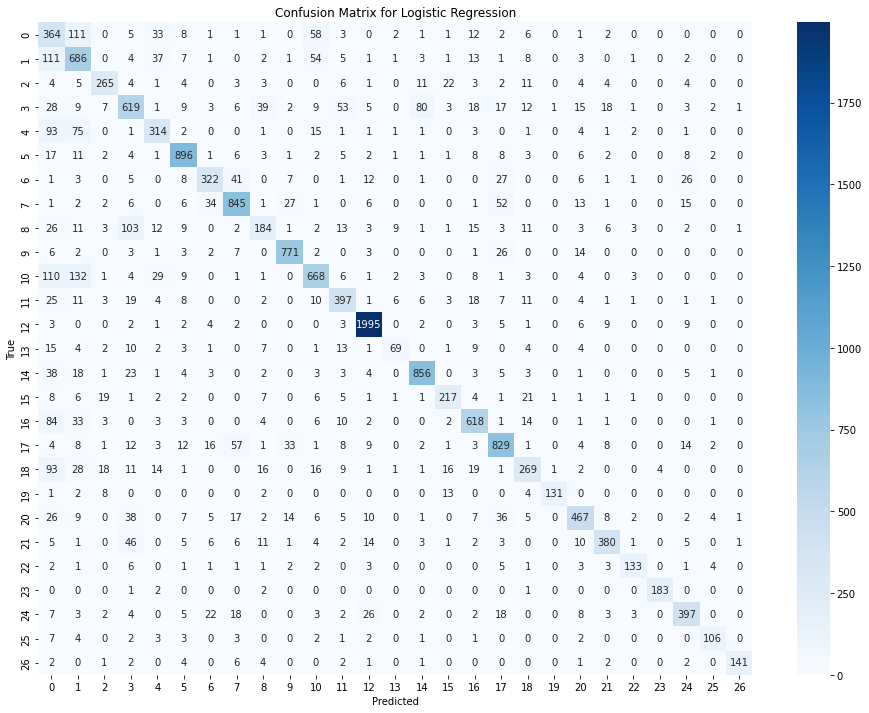

In [44]:
# Evaluate Logistic Regression model
y_pred = best_lr.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = clf_lr.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Logistic Regression:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(16,12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()



- **Save** the best Logistic Regression model.

In [45]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Define the full path for saving the model
model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_lr_model.joblib")

# Print where the model will be saved
print(f"Saving the model to: {model_path}")

try:
    # Save the trained Logistic Regression model using joblib
    dump(best_lr, model_path)
    print("[✔] Best Logistic Regression model saved successfully.")
except Exception as e:
    # In case of an error, print the error message
    print(f"[X] Error occurred while saving the model: {e}")

Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical\best_lr_model.joblib
[✔] Best Logistic Regression model saved successfully.


###  4.2 Support Vector Machines (SVM)

To optimize the **Support Vector Machines (SVM)** model, we perform a **GridSearchCV** on selected hyperparameters, aiming to maximize the **weighted F1-score** to effectively handle class imbalances:

- **`C`** → Regularization strength:  
  - **Lower values (e.g., `0.1`)** apply stronger regularization, which can help prevent overfitting but may underfit the data.  
  - **Higher values (e.g., `10`)** reduce regularization, allowing the model to fit more complex decision boundaries but increasing overfitting risk.  
- **`kernel`** → Specifies the type of decision boundary:  
  - **`linear`** is chosen as it is well-suited for high-dimensional text data (e.g., TF-IDF representations), ensuring efficient and interpretable decision boundaries.  

Other hyperparameters such as `gamma` are **not required** for a linear kernel and are omitted to simplify the optimization process.  


- **GridSearchCV** for SVM

In [9]:
%%time

# Define parameter grid for SVM
# Updated hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength: higher values reduce regularization (risk of overfitting)
    'kernel': ['linear'],  # Linear kernel is the best choice for text classification (works well with TF-IDF)
}


# Initialize the SVM model
svm = SVC()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_svm = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for SVM: {grid_search.best_params_}")


Best Hyperparameters for SVM: {'C': 1, 'kernel': 'linear'}
Wall time: 14min 32s


- **Re-train** SVM with the best hyperparameters.

In [10]:
%%time

# After GridSearchCV has finished

best_svm = SVC(
    C=grid_search.best_params_['C'],
    kernel=grid_search.best_params_['kernel']
)
best_svm.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"Kernel: {grid_search.best_params_['C']}\n"
      f"C: {grid_search.best_params_['kernel']}")


Model retrained with the following best hyperparameters:
Kernel: 1
C: linear
Wall time: 4min 27s


- **Evaluate** SVM with the best hyperparameters.

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.31      0.65      0.42       612
           1       0.58      0.73      0.64       942
           2       0.77      0.78      0.78       357
           3       0.66      0.69      0.68       961
           4       0.79      0.56      0.65       517
           5       0.89      0.90      0.89       991
           6       0.75      0.71      0.73       462
           7       0.85      0.83      0.84      1013
           8       0.65      0.43      0.52       424
           9       0.89      0.93      0.91       841
          10       0.79      0.67      0.72       986
          11       0.72      0.75      0.74       539
          12       0.96      0.97      0.97      2047
          13       0.71      0.51      0.59       146
          14       0.93      0.87      0.90       974
          15       0.76      0.73      0.74       306
          16       0.84      0.77      0.80       

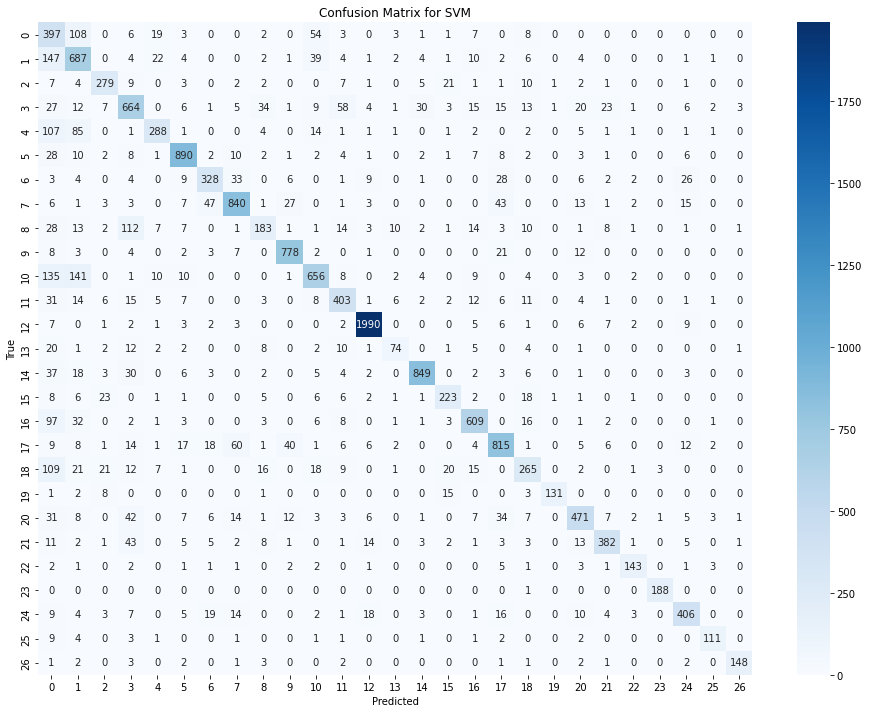

In [11]:
# Evaluate SVM model
y_pred = best_svm.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_svm.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for SVM:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for SVM")
plt.show()


- **Save** the best SVM model.

In [22]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Define the path to save the SVM model
svm_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_svm_model.joblib")

print(f"Saving the model to: {svm_model_path}")

try:
    # Save the trained SVM model using joblib
    dump(best_svm, svm_model_path)
    print("[✔] Best SVM model saved successfully.")
except Exception as e:
    # Handle any errors during saving
    print(f"[X] Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical\best_svm_model.joblib
[✔] Best SVM model saved successfully.


### 4.3 Random Forest Classifier  

To optimize the **Random Forest Classifier** model, we perform a **GridSearchCV** on selected hyperparameters, aiming to maximize the **weighted F1-score**, which helps in handling class imbalances effectively.  

- **`n_estimators`** → The number of trees in the forest:  
  - **`100`** (default) ensures a reasonable balance between performance and speed.  
  - **`300`** is tested to improve stability and robustness.  
- **`max_features`** → Number of features considered for each split:  
  - **`'sqrt'`** is kept as it works well for high-dimensional text data, reducing computational cost without sacrificing performance.  
- **`min_samples_split`** → Minimum samples required to split a node:  
  - **`2`** allows deeper splits, capturing more details but increasing overfitting risk.  
  - **`4`** imposes a stricter splitting rule to enhance generalization.  
- **`max_depth`** → Limits the depth of trees:  
  - **`None`** allows the trees to grow fully, capturing more complex patterns.  
  - **`20`** provides a reasonable cutoff to prevent excessive overfitting.  

Other hyperparameters, such as `min_samples_leaf`, `class_weight`, and `bootstrap`, are left to their default values to focus on optimizing tree depth, feature selection, and split behavior.  


- **GridSearchCV** for Random Forest

In [13]:
%%time

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 300],  # Number of trees in the forest (default 100, testing up to 300 for better stability)
    'max_features': ['sqrt'],  # Keeping only 'sqrt' (faster) since 'log2' doesn't add much for text data
    'min_samples_split': [2, 4], # 2 allows deeper splits for capturing more details (risk of overfitting), while 4 limits splits to improve generalization
    'max_depth': [None, 20],  # None = full depth, 20 = reasonable limit to prevent overfitting
}
# Initialize the Random Forest model
rf = RandomForestClassifier()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_rf = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for Random Forest: {grid_search.best_params_}")


Best Hyperparameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
Wall time: 25min 35s


- **Re-train** Random Forest with the best hyperparameters.

In [14]:
%%time

# After GridSearchCV has finished
# Retrain Random Forest with the best hyperparameters
best_rf = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],  
    max_features=grid_search.best_params_['max_features'],  
    min_samples_split=grid_search.best_params_['min_samples_split'], 
    max_depth=grid_search.best_params_['max_depth']  
)

# Train the model with the best parameters
best_rf.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"n_estimators: {grid_search.best_params_['n_estimators']}\n"
      f"max_features: {grid_search.best_params_['max_features']}\n"
      f"min_samples_split: {grid_search.best_params_['min_samples_split']}\n"
      f"max_depth: {grid_search.best_params_['max_depth']}")


Model retrained with the following best hyperparameters:
n_estimators: 300
max_features: sqrt
min_samples_split: 2
max_depth: None
Wall time: 14min 13s


- **Evaluate** Random Forest with the best hyperparameters.

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.33      0.57      0.42       612
           1       0.62      0.68      0.65       942
           2       0.81      0.71      0.75       357
           3       0.67      0.60      0.63       961
           4       0.70      0.56      0.62       517
           5       0.83      0.88      0.85       991
           6       0.75      0.67      0.71       462
           7       0.78      0.81      0.79      1013
           8       0.59      0.50      0.54       424
           9       0.89      0.91      0.90       841
          10       0.73      0.70      0.71       986
          11       0.67      0.72      0.69       539
          12       0.93      0.98      0.95      2047
          13       0.68      0.51      0.58       146
          14       0.84      0.89      0.87       974
          15       0.72      0.75      0.73       306
          16       0.78      0.78      0

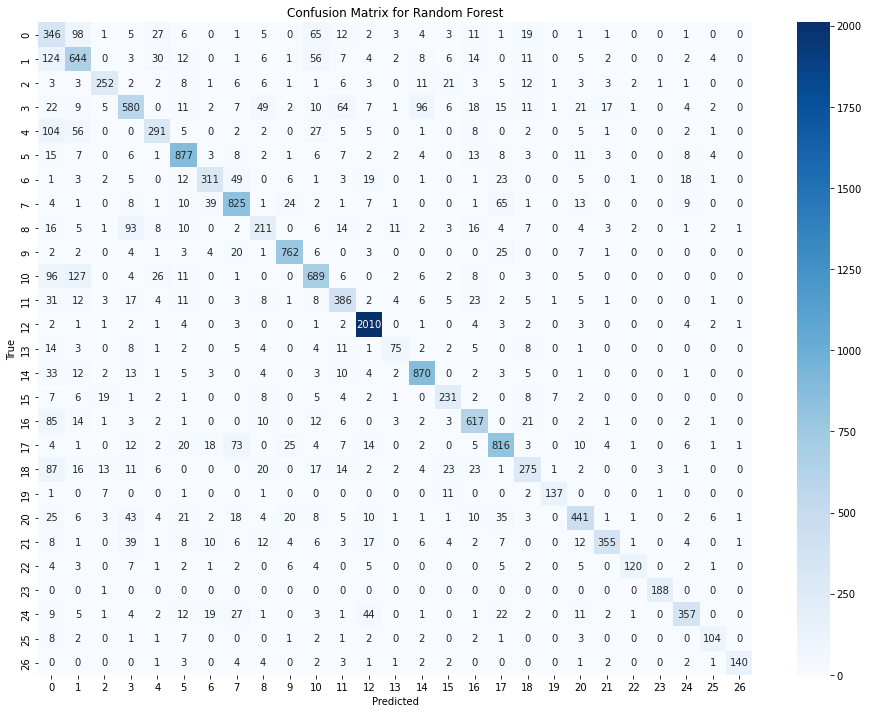

In [15]:
# Evaluate Random Forest model
y_pred = best_rf.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_rf.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Random Forest:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Random Forest")
plt.show()


- **Save** the best Random Forest model.

In [23]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Define the path to save the Random Forest model
rf_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_rf_model.joblib")

print(f"Saving the model to: {rf_model_path}")

try:
    # Save the trained Random Forest model using joblib
    dump(best_rf, rf_model_path)
    print("[✔] Best Random Forest model saved successfully.")
except Exception as e:
    # Handle any errors during saving
    print(f"[X] Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical\best_rf_model.joblib
[✔] Best Random Forest model saved successfully.


### 4.4 K-Neighbors Classifier  

To optimize the **K-Neighbors Classifier** model, we perform a **GridSearchCV** on key hyperparameters, aiming to maximize the **weighted F1-score**, which helps handle class imbalances effectively in a multi-class text classification setting.  

- **`n_neighbors`** → The number of neighbors used for classification:  
  - **`9`** cloud provides a good balance between bias and variance.  
  - **`5`** is tested as a smaller value to check if a lower number of neighbors improves performance.  
- **`metric`** → Defines how distances are computed between points:  
  - **`'euclidean'`** (default L2 distance) is effective for continuous, well-separated data.  
  - **`'minkowski'`** generalizes distance calculations, making it adaptable to different data structures.  
- **`p`** → Defines the Minkowski power parameter:  
  - **`1`** corresponds to **Manhattan distance (L1)**, which is often more stable in high-dimensional spaces like TF-IDF.  
- **`weights`** → Determines how neighbors contribute to classification:  
  - **`'distance'`** assigns higher influence to closer neighbors, improving accuracy in imbalanced datasets.  

Other hyperparameters such as `algorithm`, `leaf_size`, and additional distance metrics are omitted to focus on the most relevant parameters for text-based classification using TF-IDF.  


- **GridSearchCV** for K-Neighbors

In [17]:
%%time

# Define parameter grid for K-Neighbors Classifier
param_grid = {
    'n_neighbors': [5, 9],  # Keep best value (9) and test a smaller one (5)
    'metric': ['euclidean', 'minkowski'],  # # Compatible with sparse TF-IDF data
    'p': [1],  # # Manhattan distance (L1) is often more stable in high-dimensional spaces like TF-IDF
    'weights': ['distance'],  # Gives higher influence to closer neighbors, reducing errors in imbalanced datasets
}

# Initialize the K-Neighbors Classifier
knn = KNeighborsClassifier()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_knn = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for K-Neighbors Classifier: {grid_search.best_params_}")

Best Hyperparameters for K-Neighbors Classifier: {'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Wall time: 6min 7s


- **Re-train** K-Neighbors Classifier with the best hyperparameters.

In [18]:
%%time

# After GridSearchCV has finished
# Retrain K-Neighbors Classifier with the best hyperparameters
best_knn = KNeighborsClassifier(
    n_neighbors=grid_search.best_params_['n_neighbors'], 
    metric=grid_search.best_params_['metric'], 
    p=grid_search.best_params_['p'],  
    weights=grid_search.best_params_['weights'] 
)

# Train the model with the best parameters
best_knn.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"n_neighbors: {grid_search.best_params_['n_neighbors']}\n"
      f"metric: {grid_search.best_params_['metric']}\n"
      f"p: {grid_search.best_params_['p']}\n"
      f"weights: {grid_search.best_params_['weights']}")


Model retrained with the following best hyperparameters:
n_neighbors: 5
metric: euclidean
p: 1
weights: distance
Wall time: 33.4 ms


- **Evaluate** K-Neighbors Classifier with the best hyperparameters.

Classification Report for K-Neighbors Classifier:
              precision    recall  f1-score   support

           0       0.11      0.59      0.19       612
           1       0.34      0.43      0.38       942
           2       0.75      0.45      0.56       357
           3       0.55      0.35      0.43       961
           4       0.12      0.10      0.11       517
           5       0.90      0.73      0.80       991
           6       0.82      0.44      0.57       462
           7       0.89      0.48      0.62      1013
           8       0.44      0.24      0.31       424
           9       0.93      0.82      0.88       841
          10       0.55      0.58      0.56       986
          11       0.57      0.61      0.59       539
          12       0.98      0.84      0.90      2047
          13       0.64      0.49      0.56       146
          14       0.77      0.64      0.70       974
          15       0.68      0.65      0.66       306
          16       0.41      0.

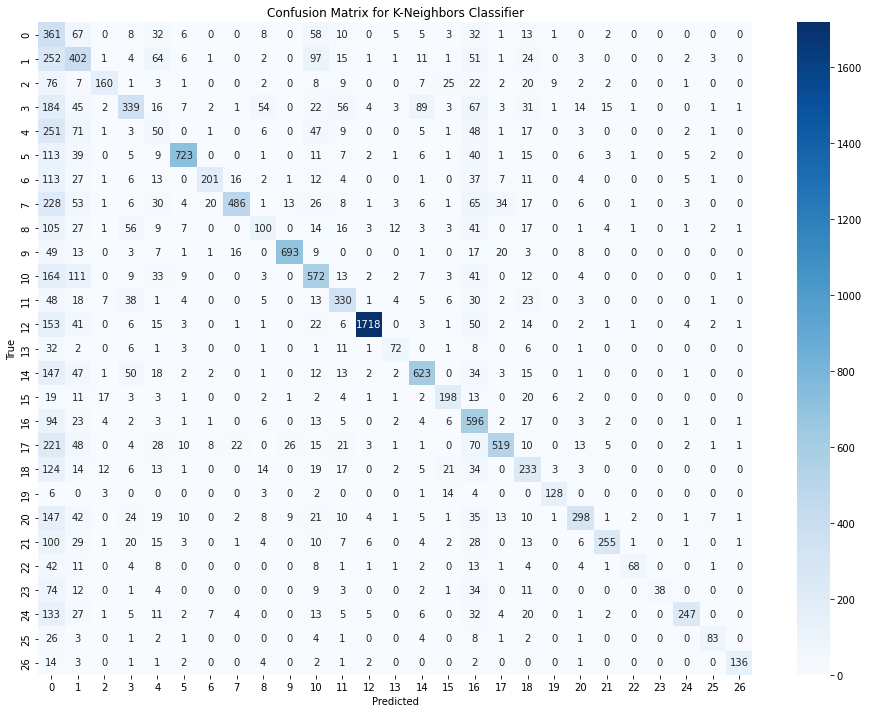

In [19]:
# Evaluate K-Neighbors Classifier model
y_pred = best_knn.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for K-Neighbors Classifier:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_knn.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for K-Neighbors Classifier:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for K-Neighbors Classifier")
plt.show()

- **Save** the best K-Neighbors model.

In [24]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Define the path to save the K-Neighbors model
knn_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_knn_model.joblib")

print(f"Saving the model to: {knn_model_path}")

try:
    # Save the trained K-Neighbors model using joblib
    dump(best_knn, knn_model_path)
    print("[✔] Best K-Neighbors model saved successfully.")
except Exception as e:
    # Handle any errors during saving
    print(f"[X] Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical\best_knn_model.joblib
[✔] Best K-Neighbors model saved successfully.


### 4.5 Decision Tree Classifier  

To optimize the **Decision Tree Classifier** model, we perform a **GridSearchCV** on key hyperparameters, aiming to maximize the **weighted F1-score**, which is crucial for handling class imbalances effectively in a multi-class text classification setting.  


- **`max_depth`** → Limits the depth of the tree to prevent overfitting:  
  - **`10, 20`** impose reasonable depth constraints while maintaining flexibility.  
  - **`None`** allows the tree to grow fully, capturing complex patterns.  
- **`min_samples_split`** → Minimum samples required to split a node:  
  - **`2`** ensures splits occur frequently, capturing fine-grained distinctions.  
  - **`5`** enforces a stricter split rule, reducing the risk of overfitting.  
- **`min_samples_leaf`** → Minimum samples required at a leaf node:  
  - **`1`** allows leaves to form even with minimal data, capturing fine details.  
  - **`2`** ensures a slightly larger sample per leaf to improve generalization.  
- **`max_features`** → Number of features considered for each split:  
  - **`'sqrt'` and `'log2'`** are both standard for handling high-dimensional data like TF-IDF.  
- **`criterion`** → Determines how the tree selects splits:  
  - **`'gini'`** (measures impurity) and **`'entropy'`** (measures information gain) are both commonly used in classification.  
- **`class_weight`** → Handles imbalanced classes:  
  - **`'balanced'`** ensures that underrepresented classes have a fair impact on learning.  

Other hyperparameters such as `splitter` are omitted in this setup to focus on optimizing depth, feature selection, and sample splits.  


- **GridSearchCV** for Decision Tree

In [25]:
%%time

# Define optimized parameter grid for Decision Tree Classifier
param_grid = {
    'max_depth': [10, 20, None],  # Restricting tree depth prevents overfitting while keeping flexibility
    'min_samples_split': [2, 5],  # Small values ensure splits happen even with fewer samples
    'min_samples_leaf': [1, 2],  # Keeps leaf nodes meaningful without excessive pruning
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],  # Both are useful for classification tasks
    'class_weight': ['balanced'],  # Ensures handling of imbalanced classes (important in our case)
}

# Initialize the Decision Tree model
dt = DecisionTreeClassifier()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_dt = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for Decision Tree: {grid_search.best_params_}")


Best Hyperparameters for Decision Tree: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Wall time: 24.8 s


- **Re-train** Decision Tree with the best hyperparameters.

In [26]:
%%time

# After GridSearchCV has finished
# Retrain Decision Tree with the best hyperparameters
best_dt = DecisionTreeClassifier(
    max_depth=grid_search.best_params_['max_depth'],  
    min_samples_split=grid_search.best_params_['min_samples_split'],  
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'], 
    max_features=grid_search.best_params_['max_features'],  
    criterion=grid_search.best_params_['criterion'],  
    class_weight=grid_search.best_params_['class_weight'] 
)

# Train the model with the best parameters
best_dt.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"max_depth: {grid_search.best_params_['max_depth']}\n"
      f"min_samples_split: {grid_search.best_params_['min_samples_split']}\n"
      f"min_samples_leaf: {grid_search.best_params_['min_samples_leaf']}\n"
      f"max_features: {grid_search.best_params_['max_features']}\n"
      f"criterion: {grid_search.best_params_['criterion']}\n"
      f"class_weight: {grid_search.best_params_['class_weight']}")


Model retrained with the following best hyperparameters:
max_depth: None
min_samples_split: 2
min_samples_leaf: 1
max_features: sqrt
criterion: gini
class_weight: balanced
Wall time: 4.13 s


- **Evaluate** Decision Tree with the best hyperparameters.

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.28      0.54      0.37       612
           1       0.59      0.53      0.56       942
           2       0.56      0.53      0.54       357
           3       0.47      0.44      0.46       961
           4       0.46      0.43      0.45       517
           5       0.75      0.73      0.74       991
           6       0.48      0.48      0.48       462
           7       0.62      0.59      0.60      1013
           8       0.44      0.41      0.42       424
           9       0.81      0.81      0.81       841
          10       0.66      0.62      0.64       986
          11       0.59      0.63      0.61       539
          12       0.87      0.91      0.89      2047
          13       0.40      0.49      0.44       146
          14       0.74      0.73      0.74       974
          15       0.61      0.64      0.62       306
          16       0.77      0.74      0

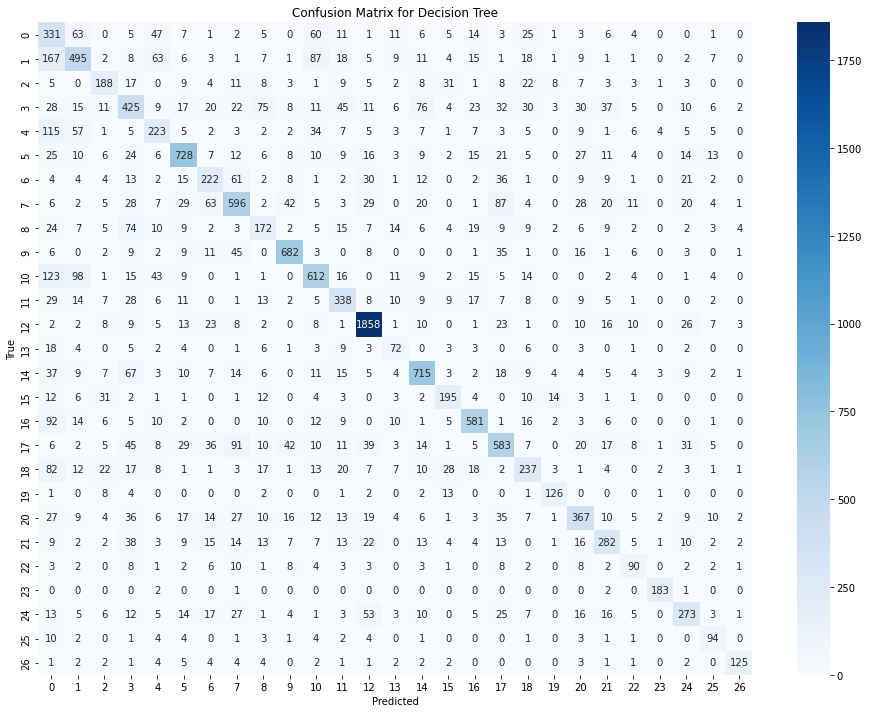

In [27]:
# Evaluate Decision Tree model
y_pred = best_dt.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_dt.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Decision Tree:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Decision Tree")
plt.show()

- **Save** the best Decision Tree model.

In [28]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Define the path to save the Decision Tree model
dt_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_dt_model.joblib")

print(f"Saving the model to: {dt_model_path}")

try:
    # Save the trained Decision Tree model using joblib
    dump(best_dt, dt_model_path)
    print("[✔] Best Decision Tree model saved successfully.")
except Exception as e:
    # Handle any errors during saving
    print(f"[X] Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical\best_dt_model.joblib
[✔] Best Decision Tree model saved successfully.


### 4.6 Linear SVC  

To optimize the **Linear SVC** model, we perform a **GridSearchCV** on selected hyperparameters, aiming to maximize the **weighted F1-score**, which is particularly useful for handling class imbalances in multi-class text classification.  

- **`C`** → Regularization parameter:  
  - **`0.5`** helps prevent underfitting.  
  - **`1.0`** (default) provides a balanced trade-off between complexity and generalization.  
  - **`1.5`** allows the model to fit more complex decision boundaries but may risk overfitting.  
- **`max_iter`** → Maximum iterations for solver convergence:  
  - **`2000, 4000`** ensure sufficient iterations without excessive computation time
- **`penalty`** → Specifies the norm used in regularization:  
  - **`'l2'`** is the standard and commonly used penalty for LinearSVC.  
- **`dual`** → Chooses between the primal and dual optimization problem:  
  - **`True`** is required for handling high-dimensional data like TF-IDF efficiently.  
- **`tol`** → Tolerance for stopping criteria:  
  - **`1e-5, 1e-4`** control the trade-off between precision and computation time.  

Other hyperparameters, such as `class_weight`, are left to their default values to focus on improving model convergence and generalization in text classification tasks.  


- **GridSearchCV** for Linear SVC

In [29]:
%%time

# Define optimized parameter grid for Linear SVC
param_grid = {
    'C': [0.5, 1.0, 1.5],  # 0.5 (avoid underfitting), 1.0 (default, balanced), 1.5 (avoid overfitting)
    'max_iter': [2000, 4000],  # iterations without excessive computation time
    'penalty': ['l2'],  # Standard for SVM with `dual=True`
    'dual': [True],  # Required for large feature spaces like TF-IDF
    'tol': [1e-5, 1e-4] 
}

# Initialize the Linear SVC model
linear_svc = LinearSVC()

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(linear_svc, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_lsvc = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for Linear SVC: {grid_search.best_params_}")


Best Hyperparameters for Linear SVC: {'C': 0.5, 'dual': True, 'max_iter': 2000, 'penalty': 'l2', 'tol': 1e-05}
Wall time: 33.3 s


- **Re-train** Linear SVC with the best hyperparameters.

In [30]:
%%time

# After GridSearchCV has finished
# Retrain Linear SVC with the best hyperparameters
best_lsvc = LinearSVC(
    C=grid_search.best_params_['C'],
    max_iter=grid_search.best_params_['max_iter'],
    penalty=grid_search.best_params_['penalty'],
    dual=grid_search.best_params_['dual'],
    tol=grid_search.best_params_['tol']
)
best_lsvc.fit(X_train, y_train)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"C: {grid_search.best_params_['C']}\n"
      f"max_iter: {grid_search.best_params_['max_iter']}\n"
      f"penalty: {grid_search.best_params_['penalty']}\n"
      f"dual: {grid_search.best_params_['dual']}\n"
      f"tol: {grid_search.best_params_['tol']}")


Model retrained with the following best hyperparameters:
C: 0.5
max_iter: 2000
penalty: l2
dual: True
tol: 1e-05
Wall time: 4.08 s


- **Evaluate** Linear SVC with the best hyperparameters.

Classification Report for Linear SVC:
              precision    recall  f1-score   support

           0       0.36      0.54      0.43       612
           1       0.60      0.70      0.65       942
           2       0.76      0.77      0.77       357
           3       0.69      0.66      0.68       961
           4       0.65      0.61      0.63       517
           5       0.89      0.91      0.90       991
           6       0.77      0.70      0.73       462
           7       0.83      0.84      0.84      1013
           8       0.60      0.44      0.51       424
           9       0.89      0.94      0.91       841
          10       0.75      0.68      0.72       986
          11       0.70      0.76      0.73       539
          12       0.95      0.98      0.97      2047
          13       0.66      0.51      0.58       146
          14       0.89      0.89      0.89       974
          15       0.73      0.71      0.72       306
          16       0.80      0.79      0.80

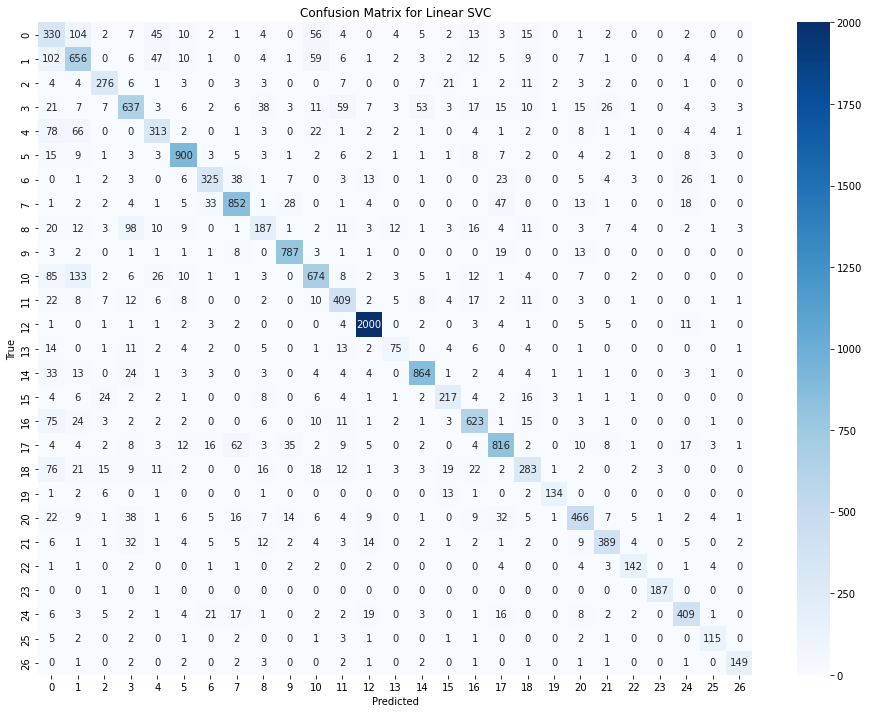

In [31]:
# Evaluate Linear SVC model
y_pred = best_lsvc.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Linear SVC:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_lsvc.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Linear SVC:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Linear SVC")
plt.show()

- **Save** the best Linear SVC model.

In [32]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Define the path to save the Linear SVC model
lsvc_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_lsvc_model.joblib")

print(f"Saving the model to: {lsvc_model_path}")

try:
    # Save the trained Linear SVC model using joblib
    dump(best_lsvc, lsvc_model_path)
    print("[✔] Best Linear SVC model saved successfully.")
except Exception as e:
    # Handle any errors during saving
    print(f"[X] Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical\best_lsvc_model.joblib
[✔] Best Linear SVC model saved successfully.


### 4.7 XGBoost  

To optimize the **XGBoost** model, we perform a **GridSearchCV** on selected hyperparameters, aiming to maximize the **weighted F1-score**, which helps handle class imbalances effectively in a multi-class text classification setting.  

- **`n_estimators`** → Number of boosting rounds (trees) to build:  
  - **`100`** ensures fast training while capturing important patterns.  
  - **`300`** allows deeper learning but prevents excessive training time.  
- **`learning_rate`** → Controls how much each tree contributes to the final prediction:  
  - **`0.05`** ensures slower but more stable learning.  
  - **`0.1`** (default) provides a balance between speed and generalization.  
  - **`0.2`** allows faster convergence but risks overfitting.  
- **`max_depth`** → Maximum depth of each tree:  
  - **`3`** is useful for regularized, fast learning.  
  - **`6`** allows capturing more complex patterns in the data.  
- **`subsample`** → Fraction of data used per tree:  
  - **`0.8`** prevents overfitting by training each tree on 80% of the data.  

Other hyperparameters, such as `min_child_weight`, `colsample_bytree`, and `gamma`, are left to their default values to maintain simplicity while ensuring a well-performing model.  


- **GridSearchCV** for XGBoost

In [33]:
%%time

# Define optimized parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 300],  # 100 (fast), 300 (better learning, avoids excessive training time)
    'learning_rate': [0.05, 0.1, 0.2],  # (0.1 as a balanced option)
    'max_depth': [3, 6],  # 3 (fast & regularized), 6 (more complex learning)
    'subsample': [0.8],  # Avoids overfitting by training on 80% of the data per tree
}

# Initialize the XGBoost model
xgb = XGBClassifier(
    use_label_encoder=False,  
    eval_metric='mlogloss',  # Explicitly set the evaluation metric
    early_stopping_rounds=10  # Stops training early if no improvement
)

# Perform GridSearchCV based on 'weighted F1-score'
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model
best_xgb = grid_search.best_estimator_

# Display best hyperparameters
print(f"Best Hyperparameters for XGBoost: {grid_search.best_params_}")


[21:18:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best Hyperparameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
Wall time: 2h 15min 26s


- **Re-train** XGBoost with the best hyperparameters.

In [34]:
%%time

# After GridSearchCV has finished
# Retrain XGBoost with the best hyperparameters
best_xgb = XGBClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],  
    learning_rate=grid_search.best_params_['learning_rate'],  
    max_depth=grid_search.best_params_['max_depth'], 
    subsample=grid_search.best_params_['subsample'],  
    use_label_encoder=False, 
    eval_metric='mlogloss', 
    early_stopping_rounds=10 
)

# Fit the model with early stopping
best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # Monitor validation loss for early stopping
    verbose=False  # Avoid excessive logging
)

# Print the best hyperparameters used for retraining
print(f"Model retrained with the following best hyperparameters:\n"
      f"n_estimators: {grid_search.best_params_['n_estimators']}\n"
      f"learning_rate: {grid_search.best_params_['learning_rate']}\n"
      f"max_depth: {grid_search.best_params_['max_depth']}\n"
      f"subsample: {grid_search.best_params_['subsample']}")


[21:28:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Model retrained with the following best hyperparameters:
n_estimators: 300
learning_rate: 0.2
max_depth: 6
subsample: 0.8
Wall time: 9min 49s


- **Evaluate** XGBoost with the best hyperparameters.

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.30      0.65      0.41       612
           1       0.62      0.68      0.65       942
           2       0.79      0.75      0.77       357
           3       0.72      0.70      0.71       961
           4       0.77      0.57      0.65       517
           5       0.88      0.88      0.88       991
           6       0.77      0.73      0.75       462
           7       0.86      0.84      0.85      1013
           8       0.61      0.53      0.57       424
           9       0.91      0.92      0.91       841
          10       0.74      0.68      0.71       986
          11       0.72      0.71      0.72       539
          12       0.96      0.97      0.97      2047
          13       0.70      0.56      0.62       146
          14       0.93      0.89      0.91       974
          15       0.72      0.72      0.72       306
          16       0.82      0.77      0.79   

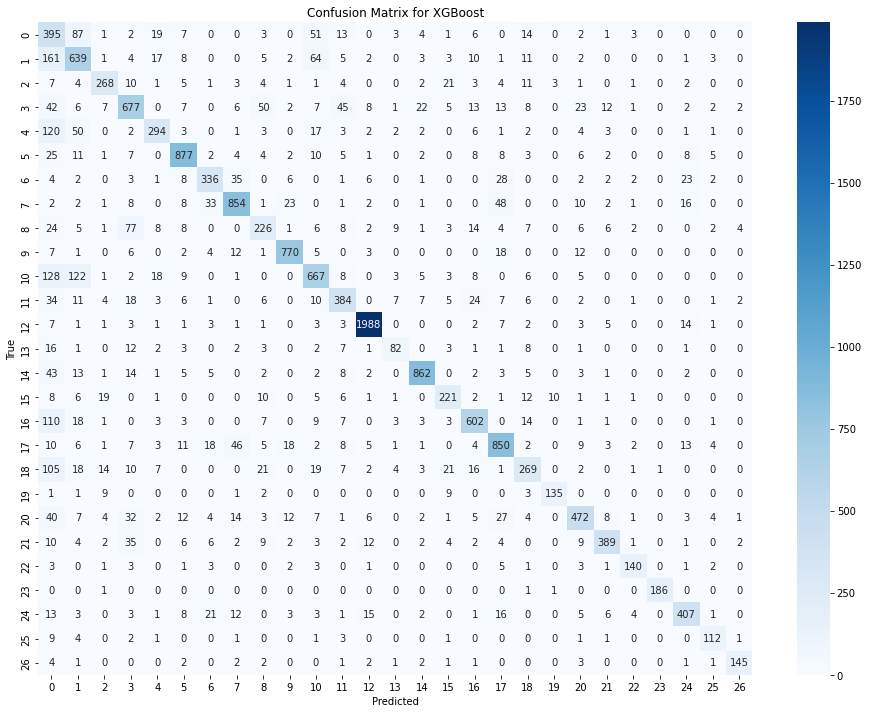

In [35]:
# Evaluate XGBoost model
y_pred = best_xgb.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = best_xgb.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for XGBoost:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for XGBoost")
plt.show()

- **Save** the best XGBoost model.

In [36]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Define the path to save the XGBoost model
xgb_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_xgb_model.joblib")

print(f"Saving the model to: {xgb_model_path}")

try:
    # Save the trained XGBoost model using joblib
    dump(best_xgb, xgb_model_path)
    print("[✔] Best XGBoost model saved successfully.")
except Exception as e:
    # Handle any errors during saving
    print(f"[X] Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical\best_xgb_model.joblib
[✔] Best XGBoost model saved successfully.


## 5. Creating a Voting Classifier
- **Combine** all the best models trained in the previous steps using a **Voting Classifier**.

### Voting Classifier Strategy

The decision between **Soft Voting** and **Hard Voting** depends on whether the models in the ensemble support probability predictions (`predict_proba()`):  

- **Soft Voting** is used when all models support `predict_proba()`. Each model provides a probability distribution over the classes, and the final prediction is based on the average of these probabilities.  

- **Soft Voting with selected models** is applied when only some models support `predict_proba()`. In this case, we exclude the models that do not provide probabilities and perform Soft Voting with the remaining compatible models.  

- **Hard Voting** is used when none of the models support `predict_proba()`. Instead of averaging probabilities, Hard Voting takes the class predicted by the majority of the models.  

**Soft Voting is generally more accurate** because it considers the confidence of each model in its predictions.  
 **Hard Voting is more robust** against individual model errors but tends to be **less precise** since it relies only on the majority vote.  

**In summary, Soft Voting is preferred if all models support it. Otherwise, the strategy is adjusted based on the available model capabilities.**


### Handling Soft & Hard Voting Automatically

In [ ]:
%%time

# [✔] List of trained models
models = [
    ('lr', best_lr),    # Logistic Regression
    ('svm', best_svm),  # Support Vector Machine
    ('rf', best_rf),    # Random Forest
    ('knn', best_knn),  # K-Nearest Neighbors
    ('dt', best_dt),    # Decision Tree
    ('lsvc', best_lsvc), # Linear SVC
    ('xgb', best_xgb)  # XGBoost
]

# [✔] Check which models support `predict_proba()` and `predict()`
models_with_proba = [m for m in models if hasattr(m[1], 'predict_proba')]
models_with_predict = [m for m in models if hasattr(m[1], 'predict')]

# [✔] Choose voting method based on model capabilities
if len(models_with_proba) == len(models):
    # All models support `predict_proba()`, use SOFT VOTING
    voting_clf = VotingClassifier(estimators=models, voting='soft')
    print("[✔] All models support `predict_proba()`. Using SOFT voting.")
elif len(models_with_proba) > 0 and len(models_with_predict) == len(models):
    # Some models do not support `predict_proba()`, remove them for SOFT VOTING
    print("/!\ Some models do not support `predict_proba()`. Using SOFT voting with compatible models only.")
    voting_clf = VotingClassifier(estimators=models_with_proba, voting='soft')
elif len(models_with_predict) == len(models):
    # No model supports `predict_proba()`, switch to HARD VOTING
    voting_clf = VotingClassifier(estimators=models, voting='hard')
    print("/!\ No model supports `predict_proba()`. Switching to HARD voting.")
else:
    raise ValueError("[X] No compatible models found for VotingClassifier. Please check your models.")

# Train the Voting Classifier
# Even though all models are already trained, you must call .fit()
#so that the Voting Classifier knows how to aggregate predictions
#Does not retrain individual models.
voting_clf.fit(X_train, y_train)

print(f"[✔] Voting Classifier trained with {'soft' if voting_clf.voting == 'soft' else 'hard'} voting.")

"""
Cell Output:
/!\ Some models do not support `predict_proba()`. Using SOFT voting with compatible models only.
[23:15:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.
"""

- **Evaluate** Voting Classifier with the best models.

Classification Report for Voting Classifier:
              precision    recall  f1-score   support

           0       0.32      0.55      0.40       612
           1       0.62      0.66      0.64       942
           2       0.79      0.72      0.75       357
           3       0.68      0.61      0.64       961
           4       0.66      0.56      0.61       517
           5       0.87      0.88      0.87       991
           6       0.76      0.69      0.72       462
           7       0.84      0.83      0.83      1013
           8       0.58      0.47      0.52       424
           9       0.90      0.91      0.91       841
          10       0.74      0.69      0.71       986
          11       0.68      0.73      0.71       539
          12       0.94      0.98      0.96      2047
          13       0.57      0.54      0.55       146
          14       0.85      0.89      0.87       974
          15       0.70      0.75      0.72       306
          16       0.80      0.80   

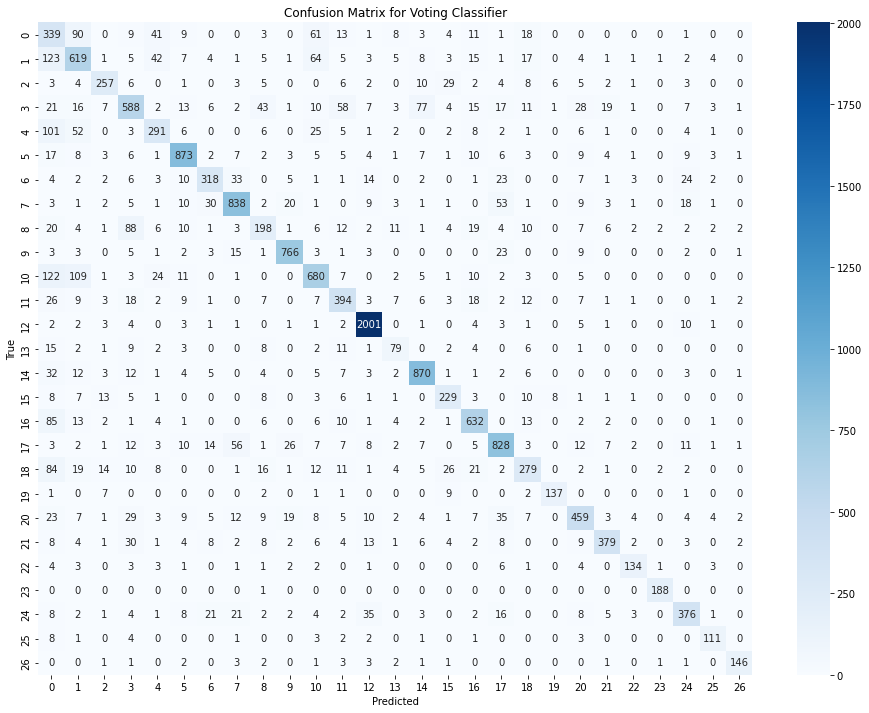

In [47]:
# Evaluate Voting Classifier model
y_pred = voting_clf.predict(X_test)  # Make predictions on the test set

# Print the classification report
print("Classification Report for Voting Classifier:")
print(classification_report(y_test, y_pred))

# Optionally, calculate other evaluation metrics like F1-Score, Accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = voting_clf.score(X_test, y_test)

# Display the evaluation metrics
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix for Voting Classifier:")
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a larger figure
plt.figure(figsize=(16,12))  # Adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Voting Classifier")
plt.show()

- **Save** the Classifier model.

In [48]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Define the path to save the Voting Classifier model
voting_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "voting_clf_model.joblib")

print(f"Saving the model to: {voting_model_path}")

try:
    # Save the trained Voting Classifier model using joblib
    dump(voting_clf, voting_model_path)
    print("[✔] Voting Classifier model saved successfully.")
except Exception as e:
    # Handle any errors during saving
    print(f"[X] Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical\voting_clf_model.joblib
[✔] Voting Classifier model saved successfully.


## Reload Saved Best Models (OPTIONAL)

In [ ]:
# #==========================================================================================
# # Load Logistic Regression Model
# #==========================================================================================
# lr_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_lr_model.joblib")

# if os.path.exists(lr_model_path):
#     try:
#         best_lr = joblib.load(lr_model_path)
#         print("[✔] Best Logistic Regression model loaded successfully.")
#     except Exception as e:
#         print(f"[X] Error loading the Logistic Regression model: {e}")
# else:
#     print(f"[X] Error: Logistic Regression model file not found at {lr_model_path}")

# #==========================================================================================
# # Load SVM Model
# #==========================================================================================
# svm_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_svm_model.joblib")

# if os.path.exists(svm_model_path):
#     try:
#         best_svm = joblib.load(svm_model_path)
#         print("[✔] Best SVM model loaded successfully.")
#     except Exception as e:
#         print(f"[X] Error loading the SVM model: {e}")
# else:
#     print(f"[X] Error: SVM model file not found at {svm_model_path}")

# #==========================================================================================
# # Load Random Forest Model
# #==========================================================================================
# rf_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_rf_model.joblib")

# if os.path.exists(rf_model_path):
#     try:
#         best_rf = joblib.load(rf_model_path)
#         print("[✔] Best Random Forest model loaded successfully.")
#     except Exception as e:
#         print(f"[X] Error loading the Random Forest model: {e}")
# else:
#     print(f"[X] Error: Random Forest model file not found at {rf_model_path}")

# #==========================================================================================
# # Load K-Nearest Neighbors (KNN) Model
# #==========================================================================================
# knn_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_knn_model.joblib")

# if os.path.exists(knn_model_path):
#     try:
#         best_knn = joblib.load(knn_model_path)
#         print("[✔] Best KNN model loaded successfully.")
#     except Exception as e:
#         print(f"[X] Error loading the KNN model: {e}")
# else:
#     print(f"[X] Error: KNN model file not found at {knn_model_path}")

# #==========================================================================================
# # Load Decision Tree Model
# #==========================================================================================
# dt_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_dt_model.joblib")

# if os.path.exists(dt_model_path):
#     try:
#         best_dt = joblib.load(dt_model_path)
#         print("[✔] Best Decision Tree model loaded successfully.")
#     except Exception as e:
#         print(f"[X] Error loading the Decision Tree model: {e}")
# else:
#     print(f"[X] Error: Decision Tree model file not found at {dt_model_path}")

# #==========================================================================================
# # Load Linear SVC Model
# #==========================================================================================
# lsvc_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_lsvc_model.joblib")

# if os.path.exists(lsvc_model_path):
#     try:
#         best_lsvc = joblib.load(lsvc_model_path)
#         print("[✔] Best Linear SVC model loaded successfully.")
#     except Exception as e:
#         print(f"[X] Error loading the Linear SVC model: {e}")
# else:
#     print(f"[X] Error: Linear SVC model file not found at {lsvc_model_path}")

# #==========================================================================================
# # Load XGBoost Model
# #==========================================================================================
# xgb_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_xgb_model.joblib")

# if os.path.exists(xgb_model_path):
#     try:
#         best_xgb = joblib.load(xgb_model_path)
#         print("[✔] Best XGBoost model loaded successfully.")
#     except Exception as e:
#         print(f"[X] Error loading the XGBoost model: {e}")
# else:
#     print(f"[X] Error: XGBoost model file not found at {xgb_model_path}")

# #==========================================================================================
# # Load Voting Classifier Model
# #==========================================================================================
# vc_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "voting_clf_model.joblib")

# if os.path.exists(vc_model_path):
#     try:
#         voting_clf = joblib.load(vc_model_path)
#         print("[✔] Voting Classifier model loaded successfully.")
#     except Exception as e:
#         print(f"[X] Error loading the Voting Classifier model: {e}")
# else:
#     print(f"[X] Error: Voting Classifier model file not found at {vc_model_path}")


## 6. Model Comparison and Selection
- **Compare** the performance of each individual model and the **Voting Classifier** using metrics like the **weighted F1-score**.
- Select the best-performing model for further use or future deployment.

In [49]:
%%time

# Create a dictionary to store the models and their respective predictions
models = {
    'Logistic Regression': best_lr,
    'SVM': best_svm,
    'Random Forest': best_rf,
    'K-Neighbors': best_knn,
    'Decision Tree': best_dt,
    'Linear SVC': best_lsvc,
    'XGBoost': best_xgb,   
    'Voting Classifier': voting_clf  
}

# Initialize an empty dictionary to store the weighted F1 scores
f1_scores = {}

# Compare the performance of each model on the test set
for model_name, model in models.items():
    # Make predictions using the model
    y_pred = model.predict(X_test)

    # Calculate the weighted F1-score for the model
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores[model_name] = f1

    # Print the classification report for each model
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

# Select the best-performing model based on the weighted F1-score
best_model_name = max(f1_scores, key=f1_scores.get)
best_model = models[best_model_name]

print(f"\nBest model based on weighted F1-score: {best_model_name} with a score of {f1_scores[best_model_name]:.4f}")


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.34      0.59      0.43       612
           1       0.58      0.73      0.65       942
           2       0.78      0.74      0.76       357
           3       0.66      0.64      0.65       961
           4       0.68      0.61      0.64       517
           5       0.88      0.90      0.89       991
           6       0.76      0.70      0.73       462
           7       0.83      0.83      0.83      1013
           8       0.62      0.43      0.51       424
           9       0.90      0.92      0.91       841
          10       0.77      0.68      0.72       986
          11       0.72      0.74      0.73       539
          12       0.95      0.97      0.96      2047
          13       0.74      0.47      0.58       146
          14       0.88      0.88      0.88       974
          15       0.77      0.71      0.74       306
          16       0.80      0.79

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.30      0.65      0.41       612
           1       0.62      0.68      0.65       942
           2       0.79      0.75      0.77       357
           3       0.72      0.70      0.71       961
           4       0.77      0.57      0.65       517
           5       0.88      0.88      0.88       991
           6       0.77      0.73      0.75       462
           7       0.86      0.84      0.85      1013
           8       0.61      0.53      0.57       424
           9       0.91      0.92      0.91       841
          10       0.74      0.68      0.71       986
          11       0.72      0.71      0.72       539
          12       0.96      0.97      0.97      2047
          13       0.70      0.56      0.62       146
          14       0.93      0.89      0.91       974
          15       0.72      0.72      0.72       306
          16       0.82      0.77      0.79  

## 7. Saving the Best Model
- **Save** the best model (Voting Classifier or other) for future use and potential deployment.

In [50]:
# Ensure the directory exists before saving the model
os.makedirs(config.CLASSICAL_MODELS_DIR, exist_ok=True)

# Define the path where the best model will be saved
best_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_model.joblib")
print(f"Saving the best model to: {best_model_path}")

try:
    # Save the best model using joblib
    dump(best_model, best_model_path)
    print(f"[✔] The best model has been saved successfully at: {best_model_path}")
except Exception as e:
    # Handle any errors during saving
    print(f"[X] Error occurred while saving the best model: {e}")


Saving the best model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical\best_model.joblib
[✔] The best model has been saved successfully at: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical\best_model.joblib


## 8. Load the Best Saved Model (Optional)

In [24]:
# Reload config to apply any updates
importlib.reload(config)

# Define the path where the best model is saved
best_model_path = os.path.join(config.CLASSICAL_MODELS_DIR, "best_model.joblib")

# Check if the model file exists before loading
if os.path.exists(best_model_path):
    try:
        # Load the saved model
        best_model = joblib.load(best_model_path)
        print(f"[✔] Best model loaded successfully from: {best_model_path}")
    except Exception as e:
        print(f"[X] Error occurred while loading the model: {e}")
        best_model = None  # Avoid errors if loading fails
else:
    print(f"[X] Model file not found at: {best_model_path}")
    best_model = None  # Avoid errors if file is missing

[✔] Best model loaded successfully from: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\classical\best_model.joblib


## 9. Customized Model Performance Analysis

This section outlines our comprehensive evaluation of the model’s classification performance, structured as follows:

- **9.1 Customized Classification Report:**  
  We start by mapping the training class numbers to the original class numbers and labels, providing clarity on performance metrics across the original categories.

- **9.2 Classification Report Generation & Class Categorization:**  
  Here, we categorize classes based on their F1-scores using thresholds derived from the Rakuten benchmark (weighted F1-score = 0.8113). This approach helps us distinguish classes that are well-classified, moderately classified, or poorly classified, thereby pinpointing areas for targeted improvement.

- **9.3 Consolidated Misclassification Report:**  
  We then dive deeper into prediction errors with a multi-layered analysis that includes:  
  - **9.3.1 Confusion Matrix Visualization with Mapped Labels:** Visualizing misclassification patterns by aligning training class numbers with the original labels.  
  - **9.3.2 Breakdown of Misclassifications:** Identifying common misclassification trends and frequently confused classes.   - **9.3.3 Detailed Misclassification Statistics:** Providing error counts and misclassification rates to highlight areas where the model underperforms.

This structured approach allows us to quickly identify strengths and focus on specific areas for improvement.


###  9.1 Customized Classification Report with Mapped Classes and Original Labels

In [23]:
import importlib
import numpy as np
import src.model_evaluation  # Initial import
importlib.reload(config)  # Force reload the module
importlib.reload(src.model_evaluation)  # Force reload the module

from src.model_evaluation import process_classification_report

# Ensure y_pred is in the correct format (class labels)
if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:  
    # XGBoost predict_proba() case → Convert probabilities to class labels
    y_pred_classes = np.argmax(y_pred, axis=-1)
    print("[ℹ] Detected probability outputs, converting to class labels using np.argmax().")
else:
    # XGBoost predict() case → Already class labels
    y_pred_classes = y_pred.astype(int)
    print("[ℹ] Detected direct class labels, using them as is.")

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)

# Display accuracy separately
print(f"\n[✔] Accuracy: {accuracy_value:.2f} (on {accuracy_support} samples)\n")

# Display final classification summary
print("\n[✔] Classification Summary Rows")
display(summary_rows)

# Display processed classification report
print("\n[✔] Processed Classification Report with Mapped Classes and Original Labels")
display(classification_df.tail(27))


[ℹ] Detected probability outputs, converting to class labels using np.argmax().

[✔] Accuracy: 0.78 (on 16984 samples)


[✔] Classification Summary Rows


,Metric Type,precision,recall,f1-score,support
28,macro avg,0.79,0.76,0.77,16984
29,weighted avg,0.80,0.78,0.79,16984



[✔] Processed Classification Report with Mapped Classes and Original Labels


,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support
0,0,10,Adult Books,0.30,0.65,0.41,612
1,1,2280,Magazines,0.62,0.68,0.65,942
2,2,50,Video Games Accessories,0.79,0.75,0.77,357
3,3,1280,Toys for Children,0.72,0.70,0.71,961
4,4,2705,Books,0.77,0.57,0.65,517
5,5,2522,Stationery,0.88,0.88,0.88,991
6,6,2582,"Furniture, Kitchen, and Garden",0.77,0.73,0.75,462
7,7,1560,Interior Furniture and Bedding,0.86,0.84,0.85,1013
8,8,1281,Board Games,0.61,0.53,0.57,424
9,9,1920,Interior Accessories,0.91,0.92,0.91,841


###  9.2 Generating a Customized Classification Report & Categorizing Classes

To assess performance, classes are categorized based on their **F1-scores** using thresholds defined relative to the **Rakuten benchmark** (RNN on text data, weighted F1-score = **0.8113**). These thresholds are designed to pinpoint areas for improvement and align with industry standards:

- **Well-classified:** **F1 ≥ Benchmark (e.g., 0.80)** – Categories that perform on par with or better than the reference model.
- **Moderately classified:** **Threshold_lower ≤ F1 < Benchmark** – Categories that may require further refinement.
- **Poorly classified:** **F1 < Threshold_lower** – Categories with notable misclassification issues.

These thresholds are **customizable** and will be adjusted based on results from baseline models in this challenge.


In [25]:
import importlib
import src.model_evaluation  # Initial import
import src.display # Initial import

importlib.reload(config)  # Force reload the module
importlib.reload(src.model_evaluation)  # Force reload the module
importlib.reload(src.display)  # Force reload the module
from src.model_evaluation import analyze_classification_performance, process_classification_report
from src.display import display_dataframe_to_user  # Import de la fonction

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)


# Define classification thresholds
WELL_CLASSIFIED_THRESHOLD = 0.80
MODERATELY_CLASSIFIED_THRESHOLD = 0.50

# Run classification performance analysis with dynamic thresholds
category_counts, well_classified, moderately_classified, poorly_classified = analyze_classification_performance(
    classification_df, 
    well_classified_threshold=WELL_CLASSIFIED_THRESHOLD, 
    moderately_classified_threshold=MODERATELY_CLASSIFIED_THRESHOLD
)

# Display summary based on dynamic thresholds
print("\n[✔] Summary of Classification Performance:")
print(f"- {category_counts.get('Well-classified', 0)} classes have an F1-score ≥ {WELL_CLASSIFIED_THRESHOLD:.2f} (Well-classified)")
print(f"- {category_counts.get('Moderate', 0)} classes have an F1-score between {MODERATELY_CLASSIFIED_THRESHOLD:.2f} and {WELL_CLASSIFIED_THRESHOLD:.2f} (Moderately classified)")
print(f"- {category_counts.get('Poorly classified', 0)} classes have an F1-score < {MODERATELY_CLASSIFIED_THRESHOLD:.2f} (Poorly classified)")


# Display detailed classification breakdown
# If `display_rows` is None (default), the entire DataFrame is shown; otherwise, it limits to `display_rows`.
display_dataframe_to_user(
    name=f"Well-Classified Categories (F1 ≥ {WELL_CLASSIFIED_THRESHOLD:.2f})",
    dataframe=well_classified.sort_values(by="f1-score", ascending=False), display_rows=None
)

display_dataframe_to_user(
    name=f"Moderately Classified Categories ({MODERATELY_CLASSIFIED_THRESHOLD:.2f} ≤ F1 < {WELL_CLASSIFIED_THRESHOLD:.2f})",
    dataframe=moderately_classified.sort_values(by="f1-score", ascending=False), display_rows=None
)

display_dataframe_to_user(
    name=f"Poorly Classified Categories (F1 < {MODERATELY_CLASSIFIED_THRESHOLD:.2f})",
    dataframe=poorly_classified.sort_values(by="f1-score", ascending=True),display_rows=None
)




[✔] Summary of Classification Performance:
- 13 classes have an F1-score ≥ 0.80 (Well-classified)
- 13 classes have an F1-score between 0.50 and 0.80 (Moderately classified)
- 1 classes have an F1-score < 0.50 (Poorly classified)

Well-Classified Categories (F1 ≥ 0.80): (showing all rows)



,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support,Quality Classification
23,23,2905,Online Distribution of Video Games,0.99,0.98,0.99,189,Well-classified
12,12,2583,Piscine and Spa,0.96,0.97,0.97,2047,Well-classified
9,9,1920,Interior Accessories,0.91,0.92,0.91,841,Well-classified
14,14,1300,Remote Controlled Models,0.93,0.89,0.91,974,Well-classified
26,26,1301,Accessories for Children,0.92,0.86,0.89,169,Well-classified
5,5,2522,Stationery,0.88,0.88,0.88,991,Well-classified
19,19,60,Games and Consoles,0.91,0.84,0.87,161,Well-classified
7,7,1560,Interior Furniture and Bedding,0.86,0.84,0.85,1013,Well-classified
22,22,2220,Supplies for Domestic Animals,0.87,0.82,0.85,170,Well-classified
17,17,2060,Decoration Interior,0.81,0.83,0.82,1029,Well-classified



Moderately Classified Categories (0.50 ≤ F1 < 0.80): (showing all rows)



,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support,Quality Classification
16,16,1160,Playing Cards,0.82,0.77,0.79,786,Moderate
2,2,50,Video Games Accessories,0.79,0.75,0.77,357,Moderate
6,6,2582,"Furniture, Kitchen, and Garden",0.77,0.73,0.75,462,Moderate
20,20,1320,Early Childhood,0.80,0.70,0.75,672,Moderate
11,11,1140,Figurines and Toy Pop,0.72,0.71,0.72,539,Moderate
15,15,2462,Games,0.72,0.72,0.72,306,Moderate
3,3,1280,Toys for Children,0.72,0.70,0.71,961,Moderate
10,10,2403,Children Books and Magazines,0.74,0.68,0.71,986,Moderate
1,1,2280,Magazines,0.62,0.68,0.65,942,Moderate
4,4,2705,Books,0.77,0.57,0.65,517,Moderate



Poorly Classified Categories (F1 < 0.50): (showing all rows)



,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support,Quality Classification
0,0,10,Adult Books,0.3,0.65,0.41,612,Poorly classified


 ###  9.3 Analyzing Misclassification Errors: A Consolidated Report

### 9.3.1 Confusion Matrix Visualization with Mapped Labels
→ Display the confusion matrix with mapped labels to visualize misclassification patterns.

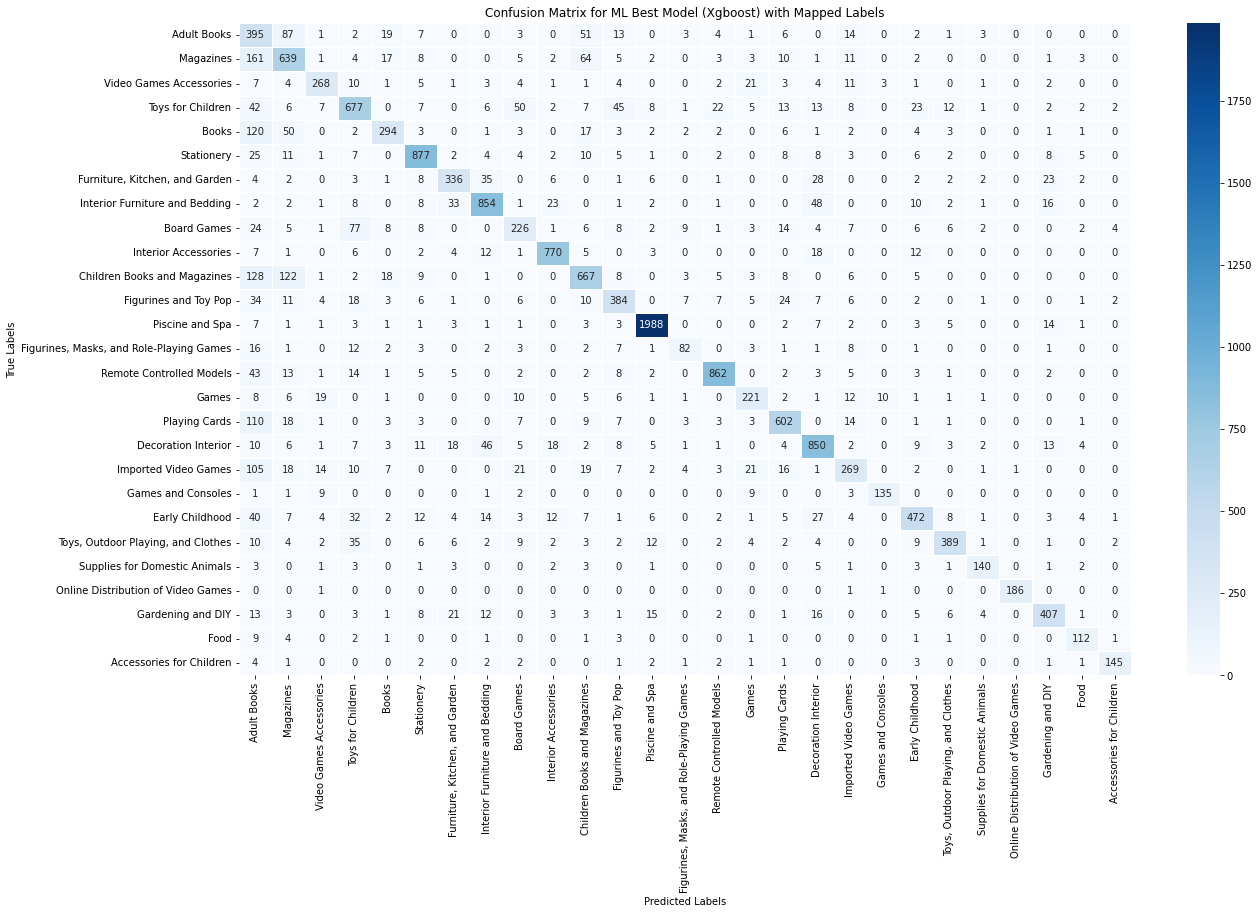

In [26]:
import importlib
importlib.reload(config)  # Reload config to ensure any updates are applied
import src.model_evaluation  # Initial import

importlib.reload(src.model_evaluation)  # Force reload the module
from src.model_evaluation import generate_confusion_matrix  

# Generate the confusion matrix with mapped labels
conf_matrix_df_labeled = generate_confusion_matrix(y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(conf_matrix_df_labeled, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for ML Best Model (Xgboost) with Mapped Labels")
plt.show()


###  9.3.2 Breakdown of Misclassifications  
→ **Analyze misclassification trends, identify the most frequently misclassified classes, and assess overall model performance.**  

In this section, we analyze the model’s misclassification patterns using a structured approach.  
We present four breakdowns to understand where the model struggles the most.  

#### **Columns in the Misclassification Table:**  
- **Encoded target** → The encoded numerical representation of each class.  
- **Original prdtypecode** → The original product category code.  
- **Class Label** → The human-readable label of the class.  
- **Samples** → The total number of instances for each class.  
- **Misclassified Count** → The number of misclassified samples for the class.  
- **Misclassification Rate (%)** → The percentage of misclassified samples within the class.  
- **Global Misclassification Rate (%)** → The percentage of misclassified samples relative to the total dataset.  

####  **Key Misclassification Perspectives**  

1. **Classes with the highest number of samples**  
   - Shows the most **frequent classes** in the dataset.  
   - Helps assess whether a class’s misclassification is due to **its high occurrence** or **its inherent difficulty**.  
   - Large classes can dominate misclassification counts even if their misclassification rate is low.  

2. **Classes with the highest number of misclassifications**  
   - Highlights the classes with the **largest absolute number of errors**.  
   - Useful for identifying which classes **contribute the most errors**, regardless of their misclassification rate.  
   - A class with many misclassifications may indicate **model weakness** or **data imbalance**.  

3. **Classes with the highest misclassification rate (%)**  
   - Identifies the classes where the model **struggles the most** proportionally.  
   - A high rate suggests **systematic confusion** in distinguishing this class from others.  
   - Small classes with a **high error rate** might require **better feature representation** or **more training data**.  

4. **Classes contributing the most to overall misclassification (%)**  
   - Measures **each class’s impact on total model errors**.  
   - A class with **many samples and a moderate error rate** can still contribute significantly to overall misclassification.  
   - Helps prioritize which classes should be improved to **reduce total model error** the most.  


By examining these four aspects, we gain insights into both **systematic classification errors** and **dataset imbalances** that could be influencing the model’s performance.  


In [27]:
import importlib

importlib.reload(config)
import src.model_evaluation  # Initial import
importlib.reload(src.model_evaluation)
from src.model_evaluation import analyze_and_display_misclassification

# Calculs déjà réalisés
misclassified_counts = conf_matrix_df_labeled.sum(axis=1) - np.diag(conf_matrix_df_labeled)
total_samples_per_class = conf_matrix_df_labeled.sum(axis=1)
misclassification_rates = round((misclassified_counts / total_samples_per_class) * 100, 2)

# [✔]Call the function with a custom number of rows to display
# You can set `display_rows` to control how many rows are shown in the notebook.
# By default, it displays 10 rows.
misclassification_analysis_df = analyze_and_display_misclassification(
    y_test, y_pred_classes, misclassified_counts, total_samples_per_class, misclassification_rates, display_rows=10
)


[✔] Misclassification analysis DataFrame created!

Top classes with the highest number of samples: (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
12,12,2583,Piscine and Spa,2047,59,2.88,0.35
17,17,2060,Decoration Interior,1029,179,17.40,1.05
7,7,1560,Interior Furniture and Bedding,1013,159,15.70,0.94
5,5,2522,Stationery,991,114,11.50,0.67
10,10,2403,Children Books and Magazines,986,319,32.35,1.88
14,14,1300,Remote Controlled Models,974,112,11.50,0.66
3,3,1280,Toys for Children,961,284,29.55,1.67
1,1,2280,Magazines,942,303,32.17,1.78
9,9,1920,Interior Accessories,841,71,8.44,0.42
16,16,1160,Playing Cards,786,184,23.41,1.08



Top classes with the highest number of misclassifications: (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
10,10,2403,Children Books and Magazines,986,319,32.35,1.88
1,1,2280,Magazines,942,303,32.17,1.78
3,3,1280,Toys for Children,961,284,29.55,1.67
18,18,40,Imported Video Games,521,252,48.37,1.48
4,4,2705,Books,517,223,43.13,1.31
0,0,10,Adult Books,612,217,35.46,1.28
20,20,1320,Early Childhood,672,200,29.76,1.18
8,8,1281,Board Games,424,198,46.70,1.17
16,16,1160,Playing Cards,786,184,23.41,1.08
17,17,2060,Decoration Interior,1029,179,17.40,1.05



Top classes with the highest misclassification rate (%): (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
18,18,40,Imported Video Games,521,252,48.37,1.48
8,8,1281,Board Games,424,198,46.70,1.17
13,13,1180,"Figurines, Masks, and Role-Playing Games",146,64,43.84,0.38
4,4,2705,Books,517,223,43.13,1.31
0,0,10,Adult Books,612,217,35.46,1.28
10,10,2403,Children Books and Magazines,986,319,32.35,1.88
1,1,2280,Magazines,942,303,32.17,1.78
20,20,1320,Early Childhood,672,200,29.76,1.18
3,3,1280,Toys for Children,961,284,29.55,1.67
11,11,1140,Figurines and Toy Pop,539,155,28.76,0.91



Top classes contributing the most to overall misclassification (%): (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
10,10,2403,Children Books and Magazines,986,319,32.35,1.88
1,1,2280,Magazines,942,303,32.17,1.78
3,3,1280,Toys for Children,961,284,29.55,1.67
18,18,40,Imported Video Games,521,252,48.37,1.48
4,4,2705,Books,517,223,43.13,1.31
0,0,10,Adult Books,612,217,35.46,1.28
20,20,1320,Early Childhood,672,200,29.76,1.18
8,8,1281,Board Games,424,198,46.70,1.17
16,16,1160,Playing Cards,786,184,23.41,1.08
17,17,2060,Decoration Interior,1029,179,17.40,1.05


###  9.3.3 Detailed Misclassification Statistics  
→ **Analyze individual misclassification cases, including total errors, misclassification rates, and overprediction trends.**  

####  Meaning of Columns in the Classification Error Analysis Table  

| **Column**                | **Description** |
|---------------------------|----------------|
| **True Label**            | The actual class of the sample in the test set (the correct category). |
| **Predicted Label**       | The incorrect class predicted by the model instead of the **True Label**. |
| **Count**                 | The number of times samples from **True Label** were misclassified as **Predicted Label**. |
| **Percentage**            | The proportion of this specific misclassification relative to **all misclassified instances**. Computed as: `(Count / Total Misclassified) * 100`. |
| **Class Sample Size** | The total number of test samples belonging to the **True Label** class (i.e., how many instances of this class exist in the test set). |
| **Misclassified Count**   | The total number of **True Label** samples that were misclassified (sum of all errors for this class). |
| **Misclassification Rate** | The error rate for the **True Label** class. Computed as: `(Misclassified Count /Class Sample Size) * 100`. |
| **Total Predicted**       | The total number of test samples predicted as belonging to the **Predicted Label** class (both correctly and incorrectly). |
| **Incorrect Predictions** | The number of test samples **incorrectly predicted** as **Predicted Label** (should have been a different class). |
| **Overprediction Rate**   | The proportion of incorrect predictions for the **Predicted Label** class. Computed as: `(Incorrect Predictions / Total Predicted) * 100`. |



In [28]:
importlib.reload(config) 
import src.model_evaluation  # Initial import
importlib.reload(src.model_evaluation)  # Force reload to use updated functions
from src.model_evaluation import generate_display_misclass_report

# Generate the enriched misclassification report
# NOTE: To display only a subset of rows, modify display_rows when calling the function
# Example: Use display_rows=20 to show only the top 20 rows:
misclassification_report = generate_display_misclass_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH, display_rows=20 # Set top_n to an integer (e.g., 20) to limit rows
)

# # Display the final enriched report
# print("\n[✔] Consolidated Misclassification Report:")
# display(misclassification_report)


Misclassification Report: (showing up to 20 rows)



,True Label,Predicted Label,Count,Percentage,Class Sample Size,Misclassified Count,Misclassification Rate,Total Predicted,Incorrect Predictions,Overprediction Rate
0,Magazines,Adult Books,161,4.31%,942,303,32.17%,1328,933,70.26%
1,Children Books and Magazines,Adult Books,128,3.43%,986,319,32.35%,1328,933,70.26%
2,Children Books and Magazines,Magazines,122,3.26%,986,319,32.35%,1023,384,37.54%
3,Books,Adult Books,120,3.21%,517,223,43.13%,1328,933,70.26%
4,Playing Cards,Adult Books,110,2.94%,786,184,23.41%,1328,933,70.26%
5,Imported Video Games,Adult Books,105,2.81%,521,252,48.37%,1328,933,70.26%
6,Adult Books,Magazines,87,2.33%,612,217,35.46%,1023,384,37.54%
7,Board Games,Toys for Children,77,2.06%,424,198,46.70%,937,260,27.75%
8,Magazines,Children Books and Magazines,64,1.71%,942,303,32.17%,897,230,25.64%
9,Adult Books,Children Books and Magazines,51,1.36%,612,217,35.46%,897,230,25.64%



[✔] Final Consolidated Report Generated!


###  9.4 **Exporting Classification Analysis to Excel** 

This step saves all classification insights into a **single Excel file** with multiple sheets for easy review.  

####  Exported Data Includes:
- **Well-Classified, Moderately Classified, Poorly Classified** categories (sorted by F1-score).  
- **Misclassification Analysis** (error rates, misclassified counts).  
- **Consolidated Misclassification Report** (detailed misclassification breakdown per class).  
- **Raw Confusion Matrix** (numerical values without labels).  

####  Output File Example:  
**`classification_analysis_<MODEL_NAME>_<TIMESTAMP>.xlsx`**  



In [31]:
import importlib
import src.model_evaluation  # Initial import
import src.export_utils  # # Initial import

importlib.reload(config) # Force reload module
importlib.reload(src.model_evaluation)  # Force reload module
importlib.reload(src.export_utils)  # Force reload module

from src.model_evaluation import analyze_and_display_misclassification, generate_display_misclass_report
from src.export_utils import export_all_analysis




# Define model name and file prefix
model_used = "ML_Best_Model_Xgboost"
file_prefix = "classification_analysis"

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)


# Compute confusion matrix
conf_matrix_df_raw = confusion_matrix(y_test, y_pred_classes)

# Convert conf_matrix_df_raw to Pandas DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix_df_raw, 
                              index=[f"True Class {label}" for label in set(y_test)],  # Index as True Labels
                              columns=[f"Pred Class {label}" for label in set(y_pred_classes)])  # Columns as Predicted Labels



# Generates and displays misclassification analysis
full_misclassification_analysis_df = analyze_and_display_misclassification(y_test,
                                                                           y_pred_classes,
                                                                           misclassified_counts,
                                                                           total_samples_per_class,
                                                                           misclassification_rates,
                                                                           display_rows=None,
                                                                           display_output=False
)

#Generates and displays a comprehensive misclassification report combining multiple analyses
full_misclassification_report = generate_display_misclass_report(y_test,
                                                                 y_pred_classes,
                                                                 config.PRDTYPECODE_MAPPING_PATH,
                                                                 display_rows=None,
                                                                display_output=False
)



dataframes_to_export = {
    "Class Categorization": {
        f"Well-Classified (F1 ≥ {WELL_CLASSIFIED_THRESHOLD:.2f})": well_classified.sort_values(by="f1-score", ascending=False),
        f"Moderately Classified ({MODERATELY_CLASSIFIED_THRESHOLD:.2f} ≤ F1 < {WELL_CLASSIFIED_THRESHOLD:.2f})": moderately_classified.sort_values(by="f1-score", ascending=False),
        f"Poorly Classified (F1 < {MODERATELY_CLASSIFIED_THRESHOLD:.2f})": poorly_classified.sort_values(by="f1-score", ascending=True),
    },
    "Misclassification Analysis": full_misclassification_analysis_df,
    "Consolidated Misclassification Report": full_misclassification_report,
    "Raw Confusion Matrix": conf_matrix_df
}

# Export all the data
export_path = export_all_analysis(
    dataframes_dict=dataframes_to_export,
    model_name=model_used,
    file_prefix=file_prefix,
    mode="text",
    classification_df=classification_df,
    summary_rows=summary_rows,
    accuracy_value=accuracy_value,
    accuracy_support=accuracy_support
)

# Print confirmation
print(f"\n[✔] Full classification analysis saved to: {export_path}")

[✔] Misclassification analysis DataFrame created!

[✔] Final Consolidated Report Generated!

[✔] Full classification analysis saved to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\reports\classification_reports\text\classification_analysis_Ml_Best_Model_Xgboost_2025-02-25_16-31-55.xlsx


## 10. Conclusion


## 11. 🔄 Next Steps

Having explored classical machine learning models for text classification, it's imperative to assess more advanced neural network architectures to enhance performance, we focused on the following models:

- **RNN with GRU Cell (RNN-GRUCell)**: This architecture provides granular control over each time step in sequential processing, which is particularly beneficial for custom architectures or research requiring fine manipulation of recurrent states.

- **Bidirectional Long Short-Term Memory Network (BiLSTM)**: BiLSTMs process data in both forward and backward directions, capturing past and future dependencies in a sequence, thereby offering a richer contextual understanding.

- **1D Convolutional Neural Network (Conv1D)**: Conv1D layers are effective in extracting local patterns in sequential data, identifying specific combinations of words or phrases indicative of certain classes.

- **Deep Neural Network (DNN)**: Comprising multiple fully connected layers, DNNs are powerful in modeling complex relationships within data, especially when combined with feature extraction techniques like word embeddings or TF-IDF representations.

We will first evaluate each model using an **initial configuration** to establish baseline results. Based on performance metrics, we will then **select the two best-performing models for further hyperparameter tuning** to optimize their effectiveness for our classification task.  

**Next Notebooks in This Series:**  
- *`notebooks/modeling/9_RNN_with_GRU_Cell_for_Text_Classification.ipynb`*  
- *`notebooks/modeling/10_RNN_with_LSTM_Cell_for_Text_Classification.ipynb`*  
- *`notebooks/modeling/11_1D_Convolutional_Network_for_Text_Classification.ipynb`*  
- *`notebooks/modeling/12_Simple_DNN_for_Text_Classification.ipynb`*